# Проект: Определение выгодного тарифа сотовой связи

Описание проекта. На основании имеющихся выгрузок с данными абонентов компании сотовой связи необходимо сделать вывод о тратах на сотовую связь жителями разных городов и пользователями разных тарифных планов. Так же необходимо составить представление о покупательском поведении среднего пользователя услугами компании сотовой связи.

## 1. Загрузка и получение общих сведений о данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
users_data = pd.read_csv('/datasets/users.csv')
internet_data = pd.read_csv('/datasets/internet.csv')
messages_data = pd.read_csv('/datasets/messages.csv')
calls_data = pd.read_csv('/datasets/calls.csv')
tariffs_data = pd.read_csv('/datasets/tariffs.csv')

In [3]:
users_data.columns = ['user_id','age','churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff_name']
print(users_data.head())
print(users_data.info())

   user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
2     1002   59        NaN  Стерлитамак    Евгений  Абрамович  2018-06-17   
3     1003   23        NaN       Москва      Белла   Белякова  2018-08-17   
4     1004   68        NaN  Новокузнецк    Татьяна   Авдеенко  2018-05-14   

  tariff_name  
0       ultra  
1       smart  
2       smart  
3       ultra  
4       ultra  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      500 non-null    int64 
 1   age          500 non-null    int64 
 2   churn_date   38 non-null     object
 3   city         500 non-null    object
 4   first_name   500 non-null    object
 5   last_name    500 non-null    object
 6   reg_

In [4]:
print(internet_data.head())
print(internet_data.info())

   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


In [5]:
print(calls_data.head())
print(calls_data.info())

       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


In [6]:
print(messages_data.head())
print(messages_data.info())

       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


In [7]:
tariffs_data

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Полученные данные не имеют отсутствующих значений (кроме столбца churn_date таблицы users_data). Данные колонок всех таблиц с датой представленны не в формате datetime. Приведем формат колонок, в полученных таблицах, с датой в формат datetime.

## 2. Переработка и подготовка данных

In [8]:
tariffs_data.head()
tariffs_data.columns = ['messages_included', 'mb_per_month_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb','rub_per_message', 'rub_per_minute', 'tariff_name']

In [9]:
users_data['reg_date']=pd.to_datetime(users_data['reg_date'])
calls_data['call_date']=pd.to_datetime(calls_data['call_date'])
internet_data['session_date']=pd.to_datetime(internet_data['session_date'])
messages_data['message_date']=pd.to_datetime(messages_data['message_date'])

In [10]:
messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [11]:
calls_data['month'] = calls_data['call_date'].dt.month
internet_data['month'] = internet_data['session_date'].dt.month
messages_data['month'] = messages_data['message_date'].dt.month

In [12]:
messages_data.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [13]:
calls_data['duration'] = calls_data['duration'].apply(np.ceil)
calls_data

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,1.0,1499,12
202603,1499_216,2018-10-18,19.0,1499,10
202604,1499_217,2018-11-10,11.0,1499,11
202605,1499_218,2018-10-06,5.0,1499,10


перевод данных о дате в формат datetime

In [14]:
calls_data_group = calls_data.groupby(by= ['user_id', 'month']).agg({'duration':['sum', 'count']}).reset_index()
calls_data_group.columns=['user_id', 'month','calls_duration', 'calls_count']
internet_data_group = internet_data.groupby(by= ['user_id', 'month']).agg({'mb_used':'sum'}).reset_index()
internet_data_group.columns=['user_id', 'month','mb_used']
messages_data_group = messages_data.groupby(by= ['user_id', 'month']).agg({'id':'count'}).reset_index()
messages_data_group.columns=['user_id', 'month','message_qty']

In [15]:
messages_data_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      2717 non-null   int64
 1   month        2717 non-null   int64
 2   message_qty  2717 non-null   int64
dtypes: int64(3)
memory usage: 63.8 KB


агрегация данных о звонках, количестве полученных ГБ данных и количестве отправленных sms в разрезе пользователей и месяцев календарного года

In [16]:
total_data_one = users_data.merge(internet_data_group, on=['user_id'], how='left')

In [17]:
total_data_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3206 entries, 0 to 3205
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      3206 non-null   int64         
 1   age          3206 non-null   int64         
 2   churn_date   188 non-null    object        
 3   city         3206 non-null   object        
 4   first_name   3206 non-null   object        
 5   last_name    3206 non-null   object        
 6   reg_date     3206 non-null   datetime64[ns]
 7   tariff_name  3206 non-null   object        
 8   month        3203 non-null   float64       
 9   mb_used      3203 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 275.5+ KB


In [18]:
total_data_two = total_data_one.merge(messages_data_group, on=['user_id', 'month'], how='left').fillna(0)

In [19]:
total_data_two.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3206 entries, 0 to 3205
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      3206 non-null   int64         
 1   age          3206 non-null   int64         
 2   churn_date   3206 non-null   object        
 3   city         3206 non-null   object        
 4   first_name   3206 non-null   object        
 5   last_name    3206 non-null   object        
 6   reg_date     3206 non-null   datetime64[ns]
 7   tariff_name  3206 non-null   object        
 8   month        3206 non-null   float64       
 9   mb_used      3206 non-null   float64       
 10  message_qty  3206 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 300.6+ KB


In [20]:
total_data_three = total_data_two.merge(calls_data_group, on=['user_id', 'month'], how='left').fillna(0)

In [21]:
total_data_three.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3206 entries, 0 to 3205
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3206 non-null   int64         
 1   age             3206 non-null   int64         
 2   churn_date      3206 non-null   object        
 3   city            3206 non-null   object        
 4   first_name      3206 non-null   object        
 5   last_name       3206 non-null   object        
 6   reg_date        3206 non-null   datetime64[ns]
 7   tariff_name     3206 non-null   object        
 8   month           3206 non-null   float64       
 9   mb_used         3206 non-null   float64       
 10  message_qty     3206 non-null   float64       
 11  calls_duration  3206 non-null   float64       
 12  calls_count     3206 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(5)
memory usage: 350.7+ KB


In [22]:
total_data = total_data_three.merge(tariffs_data, on='tariff_name', how='left')

In [23]:
set(users_data['user_id']) - set(total_data['user_id'])

set()

произведено сравнение таблицы users_data и total_data. все значения из таблицы users_data представлены в таблице total_data

In [24]:
total_data['gb_used'] = (total_data ['mb_used']/1024).apply(np.ceil)
total_data['gb_per_month_included'] = total_data ['mb_per_month_included']/1024

In [25]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3206 entries, 0 to 3205
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3206 non-null   int64         
 1   age                    3206 non-null   int64         
 2   churn_date             3206 non-null   object        
 3   city                   3206 non-null   object        
 4   first_name             3206 non-null   object        
 5   last_name              3206 non-null   object        
 6   reg_date               3206 non-null   datetime64[ns]
 7   tariff_name            3206 non-null   object        
 8   month                  3206 non-null   float64       
 9   mb_used                3206 non-null   float64       
 10  message_qty            3206 non-null   float64       
 11  calls_duration         3206 non-null   float64       
 12  calls_count            3206 non-null   float64       
 13  mes

произвели объединение таблиц о количестве минут, smd и гигабайт в единую таблицу

In [26]:
def services_pay_month (row):
    total = 0
    total = row['rub_monthly_fee']
    if row['calls_duration']>row['minutes_included']:
        total += (row['calls_duration']-row['minutes_included'])*row['rub_per_minute']
    if row['message_qty']>row['messages_included']:
        total += (row['message_qty']-row['messages_included'])*row['rub_per_message']
    if row['gb_used']>row['gb_per_month_included']:
        total += (row['gb_used']-row['gb_per_month_included'])*row['rub_per_gb']
    return total

In [27]:
def services_for_month (row):
    mins = (row['calls_duration']-row['minutes_included'])*row['rub_per_minute']
    sms = (row['message_qty']-row['messages_included'])*row['rub_per_message']
    gb = (row['gb_used']-row['gb_per_month_included'])*row['rub_per_gb']
    total = 0
    for i in [mins, sms, gb]:
        if i>0:
            total +=i
    return total
            

In [28]:
total_data['services_fee'] = total_data.apply(lambda x: services_for_month(x), axis=1)

In [29]:
total_data['total_pay'] = total_data['services_fee']+total_data['rub_monthly_fee']

In [30]:
total_data['total_pay_alt'] = total_data.apply(services_pay_month, axis=1)

In [31]:
total_data['total_pay'].sum()

4898851.0

In [32]:
total_data['total_pay_alt'].sum()

4898851.0

расчет помесячных расходов каждого пользователя и включение их в итоговую таблицу

Вывод: Полученные данные о дате и времени приведены к формату datetime. Данные собранные в таблицах о звонках, полученном количестве информации и количестве sms агрегированы по сумме и количеству (в зависимости от задания) в разрезе пользователей и месяцев. Данные из разных таблиц объеденены в общую таблицу. Расчитаны месячные расходы на услуги сотовой комании.

## 3. Анализ данных

In [33]:
total_data.groupby('tariff_name').mean()

,user_id,age,month,mb_used,message_qty,calls_duration,calls_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used,gb_per_month_included,services_fee,total_pay,total_pay_alt
tariff_name,,,,,,,,,,,,,,,,,,,
smart,1246.472858,46.550022,8.343203,16208.386990,33.383580,417.912517,58.461642,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,16.328847,15.0,739.973531,1289.973531,1289.973531
ultra,1262.636643,46.824974,8.244626,19628.222242,49.484135,528.665302,73.640737,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,19.654043,30.0,121.136131,2071.136131,2071.136131


In [34]:
total_data.groupby('tariff_name').median()

,user_id,age,month,mb_used,message_qty,calls_duration,calls_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used,gb_per_month_included,services_fee,total_pay,total_pay_alt
tariff_name,,,,,,,,,,,,,,,,,,,
smart,1239,47,9.0,16506.84,28.0,422.0,60.0,50,15360,500,550,200,3,3,17.0,15.0,473.0,1023.0,1023.0
ultra,1277,45,9.0,19376.91,38.0,520.0,74.0,1000,30720,3000,1950,150,1,1,19.0,30.0,0.0,1950.0,1950.0


Медианные значения длительности звонков, количества звонков, количества полученных ГБ информации примерно равны средним значениям данных показателей в разрезе тарифных планов, что говорит о несмещенности выборки данных показателей (максимальные и минимальный значения не оказывают значительного влияния на средние показатели в данных категориях). Мединанные значения отправленных sms отличаются (меньше) от средних значений в разрезе тарифов, что говорит о наличии значительного количества пользователей отправивших количество SMS выше среднего.

In [35]:
total_data_mins_ultra = total_data[total_data['tariff_name']=='ultra']['calls_duration']
total_data_gb_ultra = total_data[total_data['tariff_name']=='ultra']['gb_used']
total_data_sms_ultra = total_data[total_data['tariff_name']=='ultra']['message_qty']
total_data_mins_smart = total_data[total_data['tariff_name']=='smart']['calls_duration']
total_data_gb_smart = total_data[total_data['tariff_name']=='smart']['gb_used']
total_data_sms_smart = total_data[total_data['tariff_name']=='smart']['message_qty']
total_data_pay_ultra = total_data[total_data['tariff_name']=='ultra']['total_pay']
total_data_pay_smart = total_data[total_data['tariff_name']=='smart']['total_pay']

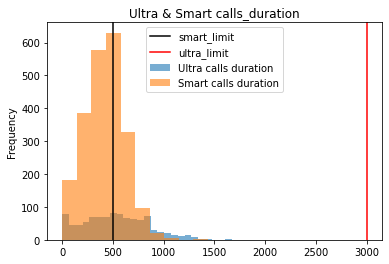

In [36]:
x1 = 500
x2 = 3000
total_data_mins_ultra.plot.hist(bins=25, alpha=0.6, title="Ultra & Smart calls_duration", label="Ultra calls duration")
total_data_mins_smart.plot.hist(alpha=0.6, label = "Smart calls duration")
plt.axvline(x=x1, label="smart_limit", color='k')
plt.axvline(x=x2, label='ultra_limit', color='r')
plt.legend()
plt.show()

форма распределения длительности звонков (помесячная каждого из пользователей) на тарифах различается. Гистограмма длительность звонков на тарифном плане Ultra имеет 3 пика в интервале 0-40 минут, в интервале 480-520 мин и в интервале 760-800 мин  и резкий обрыв в перед за длительностью разговоров в 800 минут. Правый край гистограммы на 1600 минут (лимит на тарифе 3000 минут). Форма гистограммы длительности звонков на тарифном плане Smart больше напоминает гистограмму нормального распределения с пологим левым краем и резким обрывом после 500 минут. Правый край гистограммы 1100 минут, есть выбросы с длительностью разговоров более 1200 минут (лимит на тарифе 500 минут).

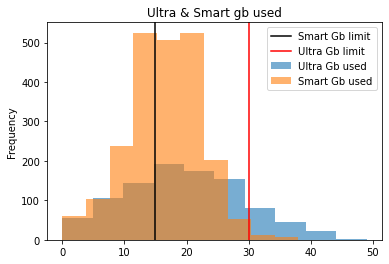

In [37]:
x1=15
x2=30
total_data_gb_ultra.plot.hist(alpha=0.6, title ="Ultra & Smart gb used", label="Ultra Gb used")
total_data_gb_smart.plot.hist(alpha=0.6, label="Smart Gb used")
plt.axvline(x=x1, label="Smart Gb limit", color='k')
plt.axvline(x=x2, label="Ultra Gb limit", color='r')
plt.legend()
plt.show()

Формы гистограмм распределения получения информации на обоих тарифных планах имеют схожую форму. При этом гистограмма получения информации на тарифе Ultra имеет резкий подъем с левого края пик в интервале 15-20 ГБ резкий обрыв в районе 30 ГБ. Крайние значения находятся на 50 ГБ(лимит 30 ГБ). Гистограмма получения информации на тарифном плане Smart имеет вершину в интервале 12-22 ГБ, резкий подъем и спад до и после этого интервала. Крайние значения находятся в районе 35 ГБ (лимит 15 ГБ)

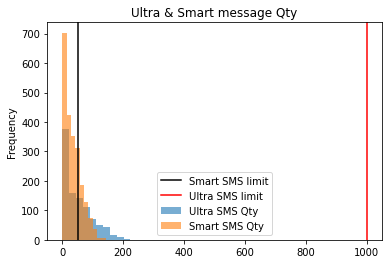

In [38]:
x1=50
x2=1000
total_data_sms_ultra.plot.hist(alpha=0.6, title = "Ultra & Smart message Qty", label = "Ultra SMS Qty")
total_data_sms_smart.plot.hist(alpha=0.6, label = "Smart SMS Qty")
plt.axvline(x=x1, label="Smart SMS limit", color='k')
plt.axvline(x=x2, label="Ultra SMS limit", color='r')
plt.legend()
plt.show()

Формы гистограмм количества отправленных sms имеют похожие формы скошенные вправо. Резкий пик гистограммы количества отправленных sms на тарифном плане Ultra находится в интервале 0-20 шт, крайние значения находятся в интревале более 200 шт (лимит 1000 шт). Резкий пик гистограммs количества отправленных sms на тарифном плане Smart находится в районе 10 шт, крайние значения находятся в интервале 120-140 шт. (лимит 50 шт)

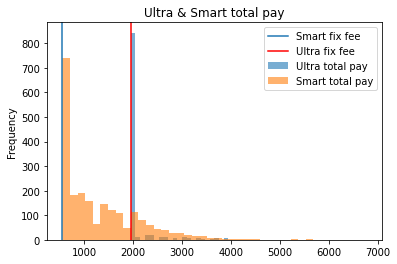

In [39]:
x1=550
x2=1950
total_data_pay_ultra.plot.hist(bins = 30, alpha = 0.6, title = "Ultra & Smart total pay", label = "Ultra total pay")
total_data_pay_smart.plot.hist(bins = 40, alpha = 0.6, label = "Smart total pay")
plt.axvline(x=x1, label="Smart fix fee")
plt.axvline(x=x2, label="Ultra fix fee", color='r')
plt.legend()
plt.show()

In [40]:
total_data[total_data['tariff_name']=='ultra'].describe()

,user_id,age,month,mb_used,message_qty,calls_duration,calls_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used,gb_per_month_included,services_fee,total_pay,total_pay_alt
count,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.0,977.0,977.0,977.0,977.0,977.0,977.0,977.000000,977.0,977.000000,977.000000,977.000000
mean,1262.636643,46.824974,8.244626,19628.222242,49.484135,528.665302,73.640737,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,19.654043,30.0,121.136131,2071.136131,2071.136131
std,141.225984,17.172374,2.886255,9972.600439,47.981618,318.199596,44.022522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.733807,0.0,377.567765,377.567765,377.567765
min,1000.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,0.000000,30.0,0.000000,1950.000000,1950.000000
25%,1143.000000,30.000000,6.000000,11919.350000,6.000000,291.000000,41.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,12.000000,30.0,0.000000,1950.000000,1950.000000
50%,1277.000000,45.000000,9.000000,19376.910000,38.000000,520.000000,74.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,19.000000,30.0,0.000000,1950.000000,1950.000000
75%,1381.000000,63.000000,11.000000,26865.250000,79.000000,752.000000,104.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,27.000000,30.0,0.000000,1950.000000,1950.000000
max,1495.000000,75.000000,12.000000,49745.690000,224.000000,1673.000000,244.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,49.000000,30.0,2850.000000,4800.000000,4800.000000


In [41]:
total_data[total_data['tariff_name']=='smart'].describe()

,user_id,age,month,mb_used,message_qty,calls_duration,calls_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used,gb_per_month_included,services_fee,total_pay,total_pay_alt
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.000000,2229.0,2229.000000,2229.000000,2229.000000
mean,1246.472858,46.550022,8.343203,16208.386990,33.383580,417.912517,58.461642,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,16.328847,15.0,739.973531,1289.973531,1289.973531
std,146.082168,16.349357,2.925653,5870.476681,28.228398,190.360058,25.943766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.747061,0.0,818.404367,818.404367,818.404367
min,1001.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,0.000000,15.0,0.000000,550.000000,550.000000
25%,1121.000000,32.000000,6.000000,12643.010000,10.000000,282.000000,40.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,13.000000,15.0,0.000000,550.000000,550.000000
50%,1239.000000,47.000000,9.000000,16506.840000,28.000000,422.000000,60.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,17.000000,15.0,473.000000,1023.000000,1023.000000
75%,1376.000000,62.000000,11.000000,20042.930000,51.000000,545.000000,76.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,20.000000,15.0,1200.000000,1750.000000,1750.000000
max,1499.000000,75.000000,12.000000,38552.450000,143.000000,1435.000000,198.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,38.000000,15.0,6220.000000,6770.000000,6770.000000


In [42]:
np.std(total_data[total_data['tariff_name']=='ultra'], ddof=1)

user_id                                  141.225984
age                                       17.172374
reg_date                 83 days 15:03:04.616363334
month                                      2.886255
mb_used                                 9972.600439
message_qty                               47.981618
calls_duration                           318.199596
calls_count                               44.022522
messages_included                               0.0
mb_per_month_included                           0.0
minutes_included                                0.0
rub_monthly_fee                                 0.0
rub_per_gb                                      0.0
rub_per_message                                 0.0
rub_per_minute                                  0.0
gb_used                                    9.733807
gb_per_month_included                           0.0
services_fee                             377.567765
total_pay                                377.567765
total_pay_al

In [43]:
np.std(total_data[total_data['tariff_name']=='smart'], ddof=1)

user_id                                  146.082168
age                                       16.349357
reg_date                 90 days 13:02:09.436012029
month                                      2.925653
mb_used                                 5870.476681
message_qty                               28.228398
calls_duration                           190.360058
calls_count                               25.943766
messages_included                               0.0
mb_per_month_included                           0.0
minutes_included                                0.0
rub_monthly_fee                                 0.0
rub_per_gb                                      0.0
rub_per_message                                 0.0
rub_per_minute                                  0.0
gb_used                                    5.747061
gb_per_month_included                           0.0
services_fee                             818.404367
total_pay                                818.404367
total_pay_al

In [44]:
np.var(total_data[total_data['tariff_name']=='ultra'], ddof=1)

user_id                  1.994478e+04
age                      2.948904e+02
month                    8.330465e+00
mb_used                  9.945276e+07
message_qty              2.302236e+03
calls_duration           1.012510e+05
calls_count              1.937982e+03
messages_included        0.000000e+00
mb_per_month_included    0.000000e+00
minutes_included         0.000000e+00
rub_monthly_fee          0.000000e+00
rub_per_gb               0.000000e+00
rub_per_message          0.000000e+00
rub_per_minute           0.000000e+00
gb_used                  9.474699e+01
gb_per_month_included    0.000000e+00
services_fee             1.425574e+05
total_pay                1.425574e+05
total_pay_alt            1.425574e+05
dtype: float64

In [45]:
np.var(total_data[total_data['tariff_name']=='smart'], ddof=1)

user_id                  2.134000e+04
age                      2.673015e+02
month                    8.559448e+00
mb_used                  3.446250e+07
message_qty              7.968425e+02
calls_duration           3.623695e+04
calls_count              6.730790e+02
messages_included        0.000000e+00
mb_per_month_included    0.000000e+00
minutes_included         0.000000e+00
rub_monthly_fee          0.000000e+00
rub_per_gb               0.000000e+00
rub_per_message          0.000000e+00
rub_per_minute           0.000000e+00
gb_used                  3.302871e+01
gb_per_month_included    0.000000e+00
services_fee             6.697857e+05
total_pay                6.697857e+05
total_pay_alt            6.697857e+05
dtype: float64

Рассчитаны дисперсии и стандартные отклонения месячных количественных значений для разных категорий услуг для разных тарифных планов. Стандартное отклонение количества звонков на тарифном плане Ultra больше чем на тарифе Smart. При схожей  длительности разговоров выборка длительности разговоров имеет больший разброс данных. Похожие ситуации в выборках данных по количеству полученной информации и sms.

Вывод: Выборки данных по тарифным планам в разрезе использованных минут и количества полученной информации не имеют большого смещения вправо, что говорит об отсутствии значимых выбросов в данных. Выборка по количеству отправленных sms на каждом из тарифных планов имеет смещение вправо за счет наличия достачного количества людей отправивших большое количество sms. Показатели стандартного отклонения говорят о том что выборка по всем показателям по тарифному плану smart более сконцентрирована (более острая) чем выборка по тарифному плану ultra (менее острая).

## 4. Проверка статистических гипотез

Сделаем выборки данных для проверки гипотез

In [46]:
total_pay_moscow = total_data[total_data['city']=='Москва']['total_pay']
total_pay_other_city = total_data[total_data['city']!='Москва']['total_pay']

Нулевая гипотеза: Средние расходы на мобильную связь пользователей Москвы и остальных городов России равны. <br>
Альтернативная гипотеза: Средние расходы на мобильную связь пользователей Москвы значительно больше чем у абонентов остальных городов России. 


In [47]:
alpha = 0.05

total_pay_moscow_mean=total_pay_moscow.mean()
total_pay_other_city_mean = total_pay_other_city.mean()
result = st.ttest_ind(total_pay_moscow, total_pay_other_city)
print(result.pvalue/2)

if (result.pvalue/2)<alpha and result.statistic>0:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')


0.2602749988628089
Не отвергаем нулевую гипотезу


In [48]:
total_pay_ultra = total_data[total_data['tariff_name']=='ultra']['total_pay']
total_pay_smart = total_data[total_data['tariff_name']=='smart']['total_pay']

Нулевая гипотеза: Средние расходы пользователей тарифов Ultra и Smart равны <br> Альтернативная гипотеза: Средние расходы пользователей тарифа Ultra значительно больше средних расходов пользователей тарифа Smart

In [50]:
alpha = 0.05

total_pay_ultra_mean = total_pay_ultra.mean()
total_pay_smart_mean = total_pay_smart.mean()
result = st.ttest_ind(total_pay_ultra, total_pay_smart, equal_var=False)
print(result.pvalue/2)

if (result.pvalue/2)<alpha and result.statistic>0:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')


9.722581639684176e-250
Отвергаем нулевую гипотезу


Вывод: Нулевая гипотеза о равенстве средних расходов на сотовую связь в Москве и регионах России не отвергается. Нулевая гипотеза о равенстве средних расходов абонентов тарифов smart и ultra отвергнута. Принимается гипотеза о том, что средние расходы абонентов тарифа ultra больше чем средние расходы абонентов тарифа smart.

## Вывод по проекту

Средние расходы абонентов на тарифе ultra больше средних расходов на тарифе smart. Соответственно тариф ultra более выгоден компании, предоставляющей услуги сотовой связи. Пользователи стараются уложиться в предоставленные им лимиты услуг, однако свободно допускают превышение (особенно на тарифе smart), установленных их тарифными планами, лимитов на услуги. Возможно введение промежуточных тарифов с большим количеством минут (1000 минут) и интернета (25ГБ) и СМС (100 шт) что было бы востребовано пользователями тарифа Smart. Возможно предусмотреть лайт тариф к тарифу Ultra включающий 1500 минут разговоров и 200 SMS и 50 ГБ интернета за меньшую фиксированную плату.